# Data Understanding — Fannie Mae (Q1 2022)

**Objective:** Assess dataset “health” before modeling:
- Class balance (default vs non-default)
- Missingness and basic data quality
- Feature distributions & outliers
- Correlations (numeric features)
- Early leakage checks (only origination-time features as inputs)

**Output:** Quick visuals + tables saved to `reports/figures/` for the report.


In [1]:
import pandas as pd

final = pd.read_csv("/kaggle/input/fannie-q1-2022-labeled/fannie_q1_2022_labeled.csv")


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


assert 'final' in globals(), "Expected a DataFrame named `final` from preprocessing."

FIG_DIR = "reports/figures"
os.makedirs(FIG_DIR, exist_ok=True)

TARGET = "default_12m"

NUMERIC_COLS = [
    "ORIG_INTEREST_RATE","ORIG_UPB","ORIG_LOAN_TERM","ORIG_LTV","ORIG_CLTV","DTI",
    "BORR_CREDIT_SCORE","CO_BORR_CREDIT_SCORE","NUM_BORROWERS","NUM_UNITS","MI_PCT"
]
CAT_COLS = [
    "FIRST_TIME_HB_FLAG","LOAN_PURPOSE","PROPERTY_TYPE","OCCUPANCY_STATUS",
    "PROPERTY_STATE","AMORTIZATION_TYPE","CHANNEL"
]


NUMERIC_COLS = [c for c in NUMERIC_COLS if c in final.columns]
CAT_COLS    = [c for c in CAT_COLS if c in final.columns]


 1) **Class Balance**
   - Expect strong imbalance (defaults are rare). For modeling, plan to use:
     - Class weights (LogisticRegression, XGBoost `scale_pos_weight`)
     - Threshold tuning
     - Possibly resampling (SMOTE/undersampling) for experiments

Rows: 11196

Class counts:
 default_12m
0    11196
Name: count, dtype: int64

Class ratio (positive rate): 0.0


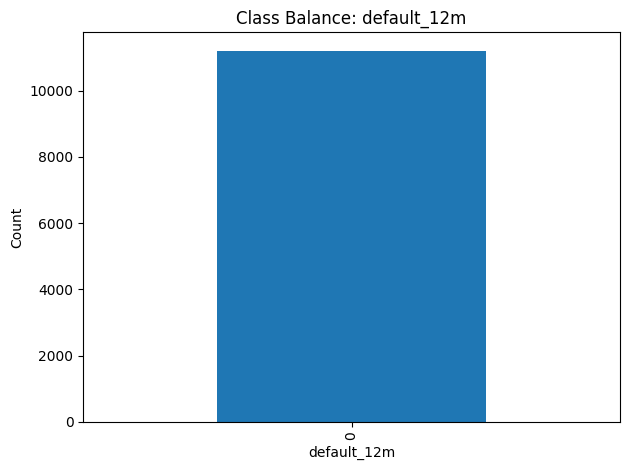

In [3]:
print("Rows:", len(final))
vc = final[TARGET].value_counts(dropna=False).sort_index()
print("\nClass counts:\n", vc)
print("\nClass ratio (positive rate):", vc.get(1, 0) / max(vc.sum(), 1))

ax = vc.plot(kind="bar")
plt.title("Class Balance: default_12m")
plt.xlabel("default_12m")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "class_balance_default_12m.png"))
plt.show()


2) **Missingness**
   - Decide on imputation strategies:
     - Numeric: median (or domain-informed)
     - Categorical: "Unknown" category
   - Drop columns with extreme missingness if they add little value.

MI_PCT                  0.779475
CO_BORR_CREDIT_SCORE    0.573151
BORR_CREDIT_SCORE       0.001340
LOAN_ID                 0.000000
FIRST_TIME_HB_FLAG      0.000000
CHANNEL                 0.000000
AMORTIZATION_TYPE       0.000000
PROPERTY_STATE          0.000000
OCCUPANCY_STATUS        0.000000
NUM_UNITS               0.000000
PROPERTY_TYPE           0.000000
LOAN_PURPOSE            0.000000
NUM_BORROWERS           0.000000
ORIGINATION_DATE        0.000000
DTI                     0.000000
ORIG_CLTV               0.000000
ORIG_LTV                0.000000
ORIG_LOAN_TERM          0.000000
ORIG_UPB                0.000000
ORIG_INTEREST_RATE      0.000000
dtype: float64


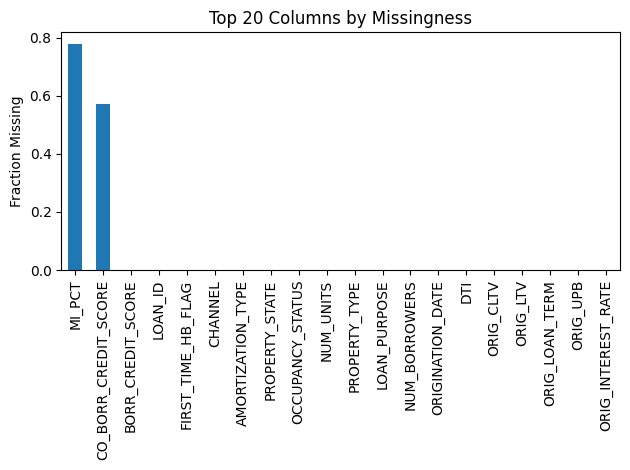

In [4]:
missing = final.isna().mean().sort_values(ascending=False)
print(missing.head(20))

ax = missing.head(20).plot(kind="bar")
plt.title("Top 20 Columns by Missingness")
plt.ylabel("Fraction Missing")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "missingness_top20.png"))
plt.show()


3) **Numeric Distributions**
   - Watch for outliers (e.g., DTI > 65, credit score < 300).
   - Consider winsorization/capping for extreme values.

In [5]:
display(final[NUMERIC_COLS].describe())

# Simple sanity flags (tweak thresholds as needed)
issues = {}

if "DTI" in final:
    issues["DTI_out_of_range"] = final["DTI"][(final["DTI"] < 0) | (final["DTI"] > 65)].index.tolist()

if "BORR_CREDIT_SCORE" in final:
    issues["BorrowerScore_out_of_range"] = final["BORR_CREDIT_SCORE"][(final["BORR_CREDIT_SCORE"] < 300) | (final["BORR_CREDIT_SCORE"] > 850)].index.tolist()

if "CO_BORR_CREDIT_SCORE" in final:
    cs = final["CO_BORR_CREDIT_SCORE"].dropna()
    issues["CoBorrowerScore_out_of_range"] = final.loc[(final["CO_BORR_CREDIT_SCORE"] < 300) | (final["CO_BORR_CREDIT_SCORE"] > 850)].index.tolist()

if "ORIG_LTV" in final:
    issues["LTV_out_of_range"] = final["ORIG_LTV"][(final["ORIG_LTV"] < 0) | (final["ORIG_LTV"] > 100)].index.tolist()

# Print a brief report
for k, idxs in issues.items():
    if len(idxs) > 0:
        print(f"{k}: {len(idxs)} rows flagged")
    else:
        print(f"{k}: OK")


,ORIG_INTEREST_RATE,ORIG_UPB,ORIG_LOAN_TERM,ORIG_LTV,ORIG_CLTV,DTI,BORR_CREDIT_SCORE,CO_BORR_CREDIT_SCORE,NUM_BORROWERS,NUM_UNITS,MI_PCT
count,11196.000000,1.119600e+04,11196.000000,11196.000000,11196.000000,11196.000000,11181.000000,4779.000000,11196.000000,11196.000000,2469.000000
mean,3.181946,2.948860e+05,320.953466,69.997678,70.119775,34.990175,752.944817,758.070098,1.437388,1.023401,26.455245
std,0.457400,1.579415e+05,72.564494,18.479645,18.458689,9.638657,45.463903,44.574993,0.516551,0.195498,6.608903
min,1.750000,1.900000e+04,96.000000,4.000000,4.000000,3.000000,569.000000,587.000000,1.000000,1.000000,6.000000
25%,2.875000,1.760000e+05,360.000000,58.000000,59.000000,28.000000,722.000000,730.000000,1.000000,1.000000,25.000000
50%,3.250000,2.640000e+05,360.000000,74.000000,74.000000,36.000000,763.000000,769.000000,1.000000,1.000000,30.000000
75%,3.375000,3.860000e+05,360.000000,80.000000,80.000000,43.000000,790.000000,794.000000,2.000000,1.000000,30.000000
max,5.000000,1.200000e+06,360.000000,97.000000,105.000000,64.000000,829.000000,829.000000,4.000000,4.000000,35.000000


DTI_out_of_range: OK
BorrowerScore_out_of_range: OK
CoBorrowerScore_out_of_range: OK
LTV_out_of_range: OK


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


### numeric distribution histogram

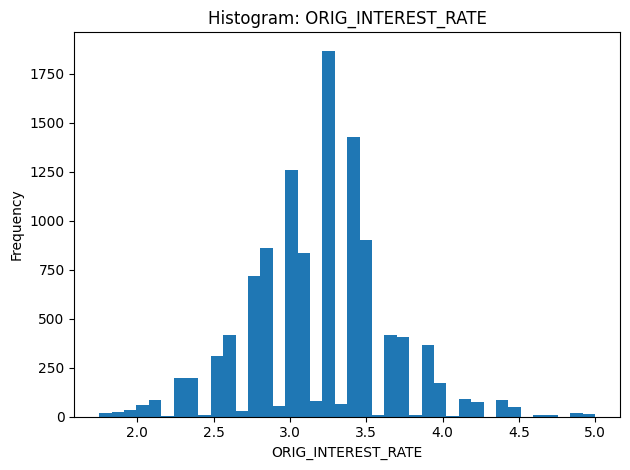

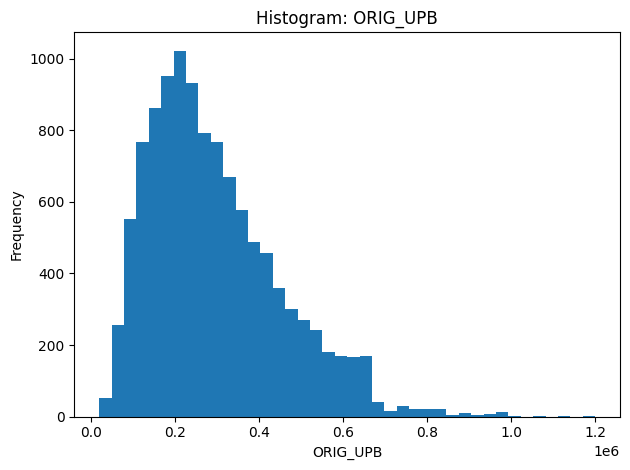

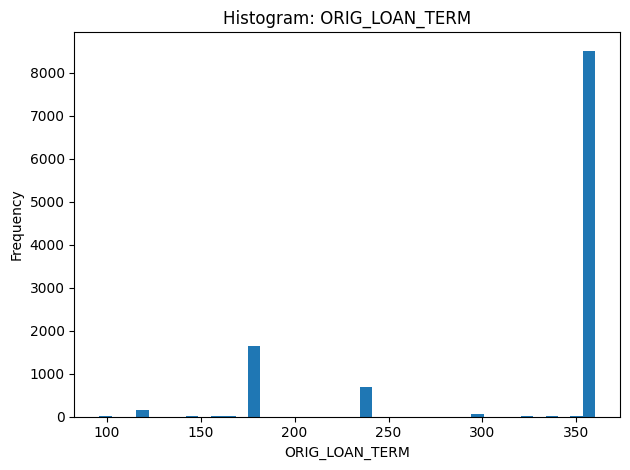

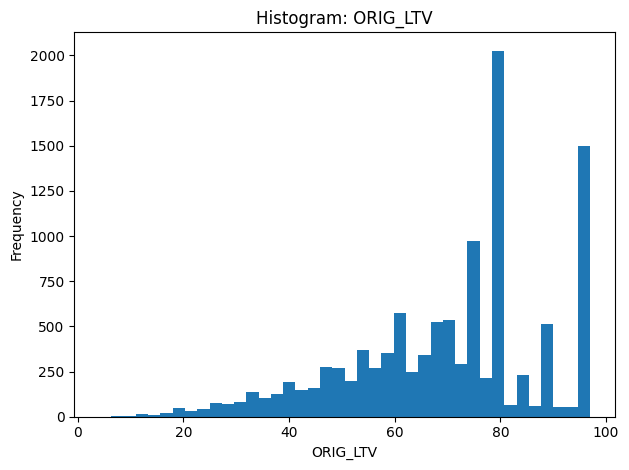

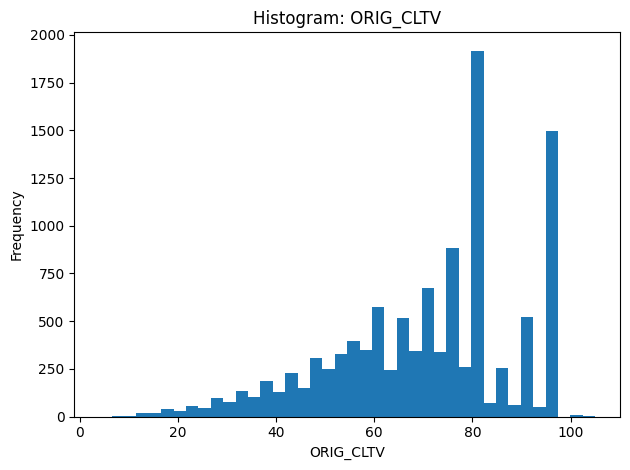

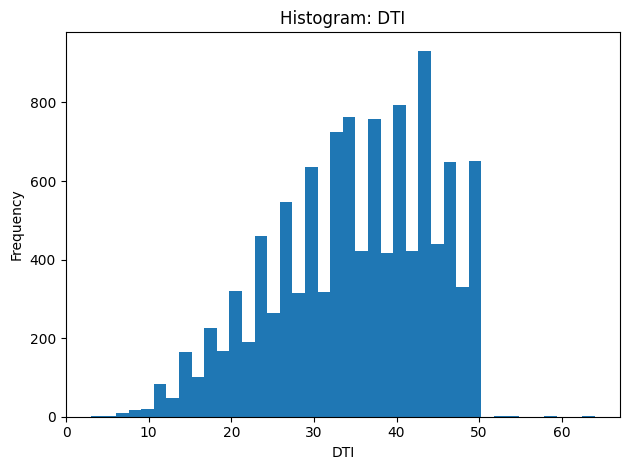

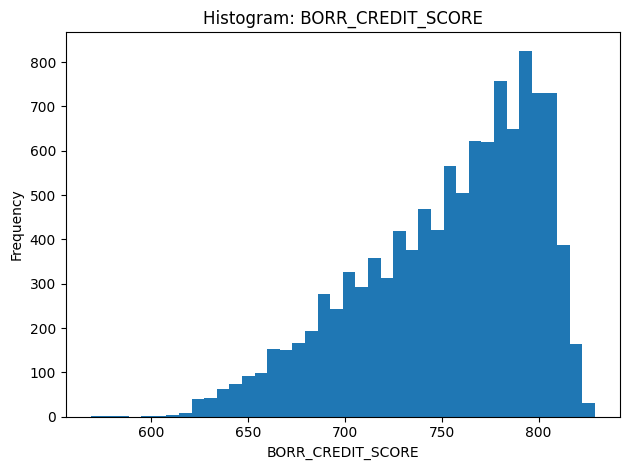

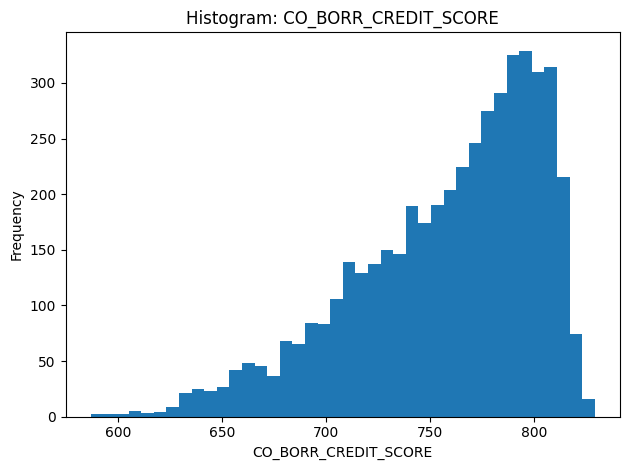

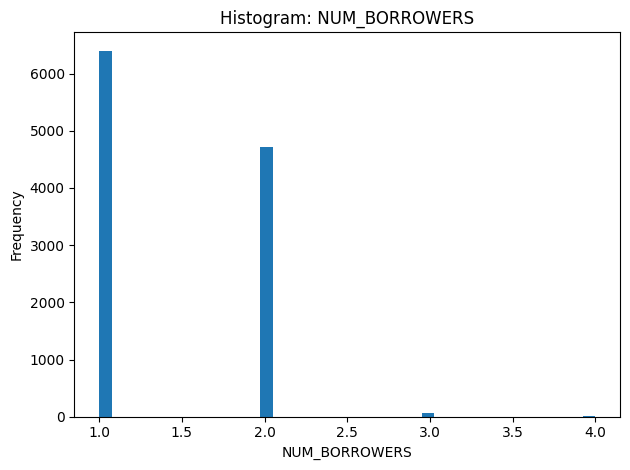

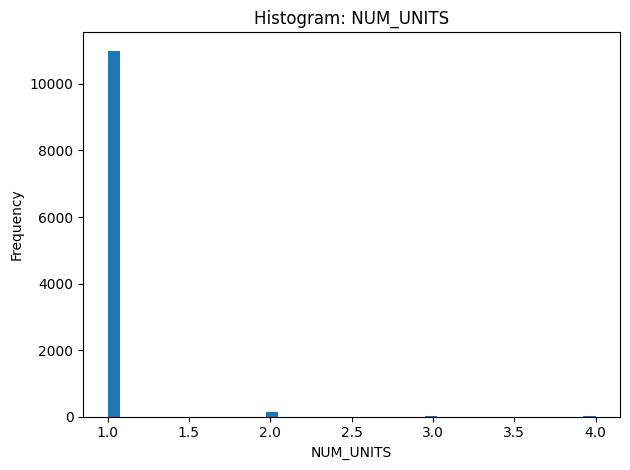

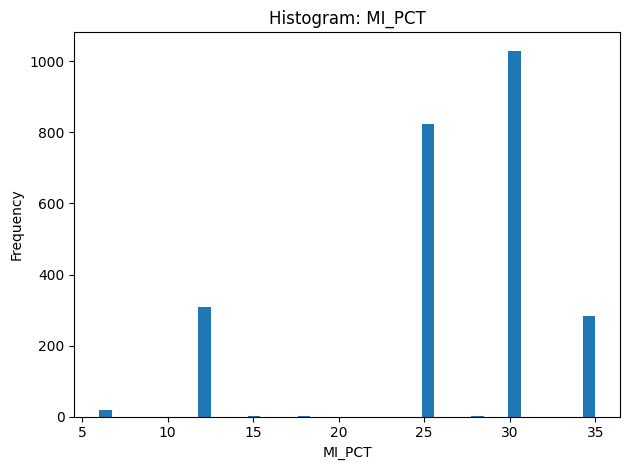

In [6]:
for col in NUMERIC_COLS:
    ax = final[col].dropna().plot(kind="hist", bins=40)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"hist_{col}.png"))
    plt.show()


4) **Categoricals**
   - High-cardinality features (e.g., PROPERTY_STATE) → one-hot may explode features.
   - Alternatives: target encoding or group rare categories into "Other".

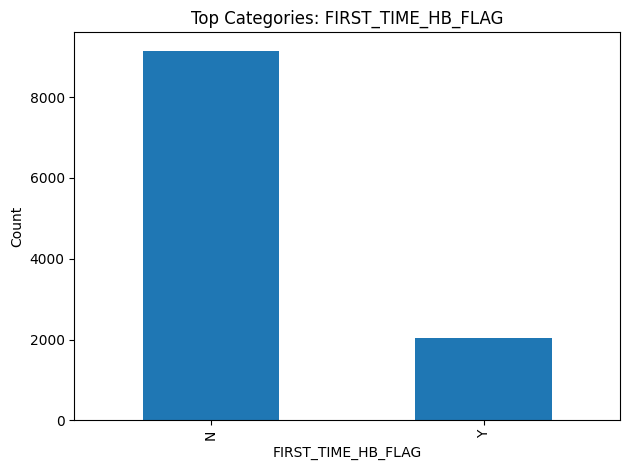

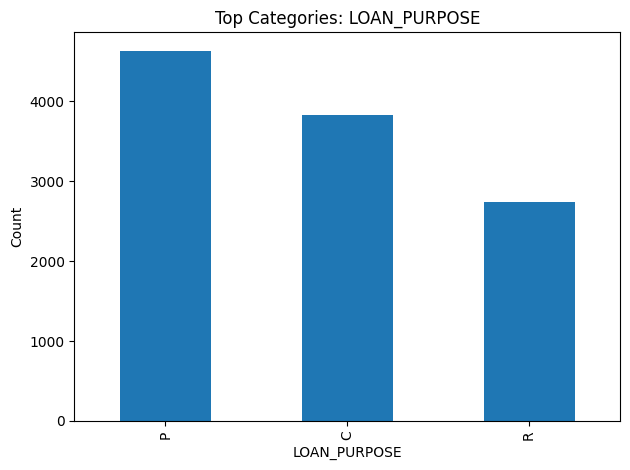

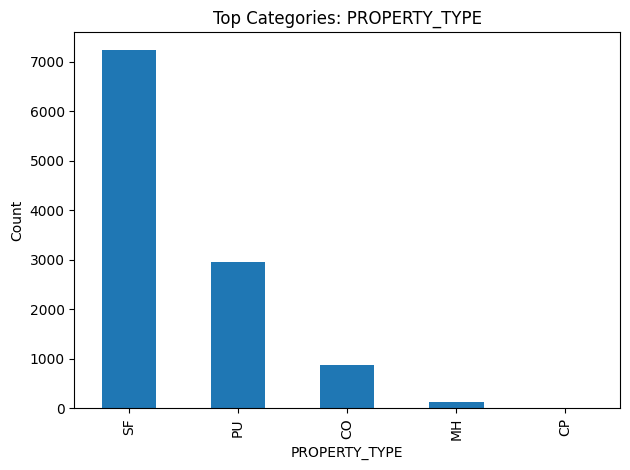

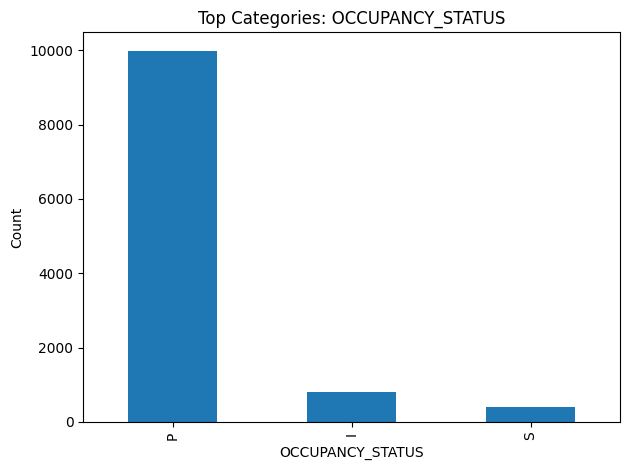

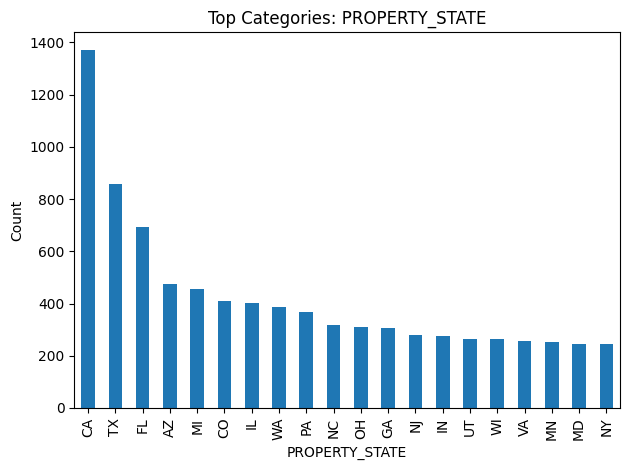

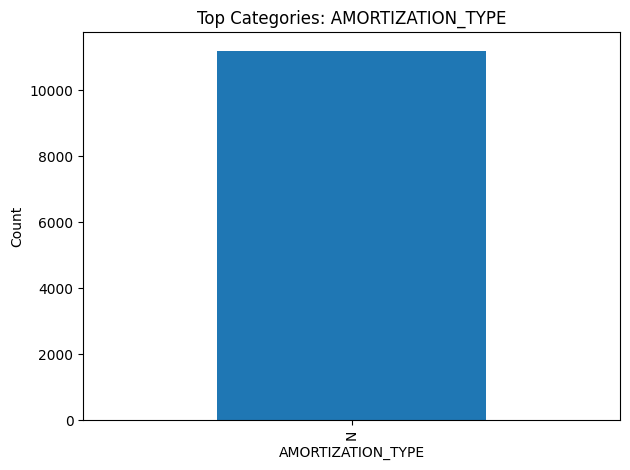

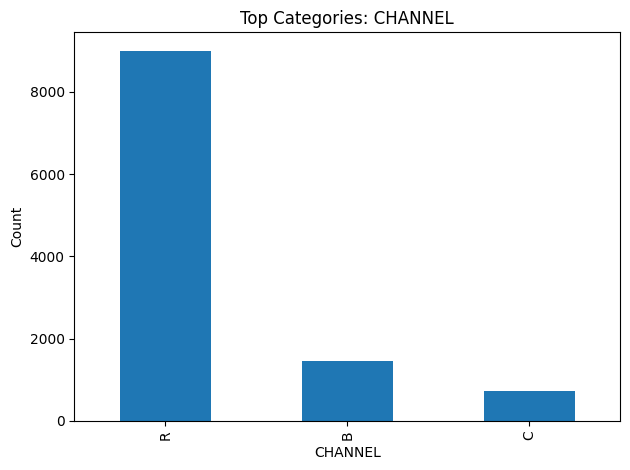

In [7]:
for col in CAT_COLS:
    vc = final[col].fillna("NA").value_counts().head(20)
    ax = vc.plot(kind="bar")
    plt.title(f"Top Categories: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"bar_{col}.png"))
    plt.show()


5) **Correlations**
   - Strong monotonic relationships (e.g., higher LTV ↔ higher default odds) are common.
   - Use this to sanity-check model coefficients later.

In [8]:
corr = final[NUMERIC_COLS + [TARGET]].corr(numeric_only=True)
display(corr)

ax = corr.style.background_gradient(cmap=None)  # default styling
display(ax)

# Also save as CSV for the report
corr.to_csv(os.path.join(FIG_DIR, "correlation_matrix.csv"))


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ORIG_INTEREST_RATE,ORIG_UPB,ORIG_LOAN_TERM,ORIG_LTV,ORIG_CLTV,DTI,BORR_CREDIT_SCORE,CO_BORR_CREDIT_SCORE,NUM_BORROWERS,NUM_UNITS,MI_PCT,default_12m
ORIG_INTEREST_RATE,1.000000,-0.069085,0.630061,0.351661,0.351899,0.130677,-0.261773,-0.276056,-0.017656,0.123828,0.150581,NaN
ORIG_UPB,-0.069085,1.000000,0.230479,0.202595,0.206393,0.131934,0.075521,0.072106,0.134356,0.029536,-0.015209,NaN
ORIG_LOAN_TERM,0.630061,0.230479,1.000000,0.399100,0.400184,0.141355,-0.076572,-0.092494,-0.039040,0.025150,0.269643,NaN
ORIG_LTV,0.351661,0.202595,0.399100,1.000000,0.996688,0.141974,-0.105074,-0.150728,-0.033825,-0.032696,0.816258,NaN
ORIG_CLTV,0.351899,0.206393,0.400184,0.996688,1.000000,0.141825,-0.106040,-0.151475,-0.033647,-0.033402,0.813111,NaN
DTI,0.130677,0.131934,0.141355,0.141974,0.141825,1.000000,-0.172822,-0.187803,-0.048654,0.025862,0.005422,NaN
BORR_CREDIT_SCORE,-0.261773,0.075521,-0.076572,-0.105074,-0.106040,-0.172822,1.000000,0.622337,0.072103,0.004591,-0.003923,NaN
CO_BORR_CREDIT_SCORE,-0.276056,0.072106,-0.092494,-0.150728,-0.151475,-0.187803,0.622337,1.000000,-0.034453,0.021821,-0.103242,NaN
NUM_BORROWERS,-0.017656,0.134356,-0.039040,-0.033825,-0.033647,-0.048654,0.072103,-0.034453,1.000000,-0.002296,0.033682,NaN
NUM_UNITS,0.123828,0.029536,0.025150,-0.032696,-0.033402,0.025862,0.004591,0.021821,-0.002296,1.000000,-0.173404,NaN


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,ORIG_INTEREST_RATE,ORIG_UPB,ORIG_LOAN_TERM,ORIG_LTV,ORIG_CLTV,DTI,BORR_CREDIT_SCORE,CO_BORR_CREDIT_SCORE,NUM_BORROWERS,NUM_UNITS,MI_PCT,default_12m
ORIG_INTEREST_RATE,1.000000,-0.069085,0.630061,0.351661,0.351899,0.130677,-0.261773,-0.276056,-0.017656,0.123828,0.150581,nan
ORIG_UPB,-0.069085,1.000000,0.230479,0.202595,0.206393,0.131934,0.075521,0.072106,0.134356,0.029536,-0.015209,nan
ORIG_LOAN_TERM,0.630061,0.230479,1.000000,0.399100,0.400184,0.141355,-0.076572,-0.092494,-0.039040,0.025150,0.269643,nan
ORIG_LTV,0.351661,0.202595,0.399100,1.000000,0.996688,0.141974,-0.105074,-0.150728,-0.033825,-0.032696,0.816258,nan
ORIG_CLTV,0.351899,0.206393,0.400184,0.996688,1.000000,0.141825,-0.106040,-0.151475,-0.033647,-0.033402,0.813111,nan
DTI,0.130677,0.131934,0.141355,0.141974,0.141825,1.000000,-0.172822,-0.187803,-0.048654,0.025862,0.005422,nan
BORR_CREDIT_SCORE,-0.261773,0.075521,-0.076572,-0.105074,-0.106040,-0.172822,1.000000,0.622337,0.072103,0.004591,-0.003923,nan
CO_BORR_CREDIT_SCORE,-0.276056,0.072106,-0.092494,-0.150728,-0.151475,-0.187803,0.622337,1.000000,-0.034453,0.021821,-0.103242,nan
NUM_BORROWERS,-0.017656,0.134356,-0.039040,-0.033825,-0.033647,-0.048654,0.072103,-0.034453,1.000000,-0.002296,0.033682,nan
NUM_UNITS,0.123828,0.029536,0.025150,-0.032696,-0.033402,0.025862,0.004591,0.021821,-0.002296,1.000000,-0.173404,nan


6) **Leakage Check**
   - Features must reflect **information available at approval time** only.
   - Exclude any performance-derived fields (we already did in the preprocessing, but re-check here).


In [9]:
# Heuristic: flag any column that obviously looks like performance or post-origination info
LEAKY_PATTERNS = ["CURR_", "ZERO_BAL", "DISPOSITION", "FORECLOSURE", "LAST_PAID", "DELINQ", "PAYMENT_HISTORY"]
suspects = [c for c in final.columns if any(pat in c.upper() for pat in LEAKY_PATTERNS)]
print("Potential leakage columns present:", suspects)

# For modeling, we will exclude any suspects from features.


Potential leakage columns present: []
